# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 



## Problem Statement
In this capstone project I aim to build machine learning models to predice if one is going response (view or complete) to the offer. To acheive that, the following approaches will be conducted:
- data preprocessing and cleaning
- exploratory data analysis (EDA)
- build machine learning models and evaluate the performence

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



## Metrics
Accuracy will be used to evaluated the models because this a simple classification problem, either: offer viewed and offer completed.

## Data Wrangling

In [1314]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
%config InlineBackend.figure_format='retina'
sb.set_style("darkgrid")

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [1315]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [1316]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [1317]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


> 10 offer id  
4 channels web, email, mobile, social  -->make them in differetn columns  
3 offer_type bogo, informational, discount

In [1318]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1319]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


Text(0, 0.5, 'Counts')

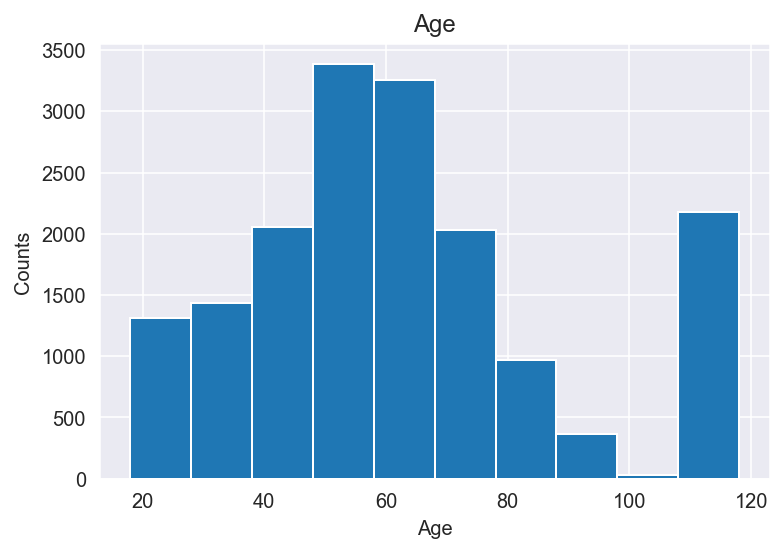

In [1320]:
plt.hist(profile['age'])
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Counts')

> age 118 shoud be incorrect

In [1321]:
profile[profile['age']==118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


> for those with age 118, they also have missing value in gender and income  

/Users/kuanchungchi/anaconda3/envs/data_udacity/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kuanchungchi/anaconda3/envs/data_udacity/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


''

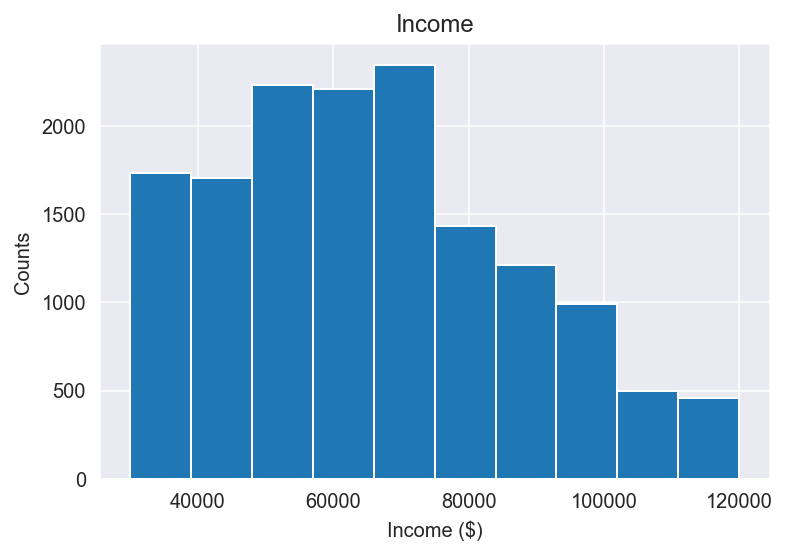

In [1322]:
plt.hist(profile['income'])
plt.title('Income')
plt.xlabel('Income ($)')
plt.ylabel('Counts')
;

In [1323]:
profile.duplicated().sum()

0

> need to change  became_member_on  to proper form   
no duplicated

In [1324]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [1325]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [1326]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

> 4 kinds of events ['offer received', 'offer viewed', 'transaction', 'offer completed']  
need to deal with the 'value' 


## Cleaning

### portfolio

In [1327]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [1328]:
channels_list=['web', 'email', 'mobile', 'social']

In [1329]:
# convert channels to different columns
for channel in channels_list:
    portfolio[channel]=portfolio['channels'].apply(lambda x:1 if channel in x else 0)

In [1330]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [1331]:
#drop the orginal columns
portfolio =portfolio.drop(['channels'],axis=1) 

In [1332]:
#rename the id to offer_id
portfolio = portfolio.rename(columns={"id": "offer_id"})

In [1333]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


### profile

In [1334]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1335]:
# rename id to user_id
profile = profile.rename(columns={"id": "user_id"})

In [1336]:
#convert became_member_on to datetime datatype
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')

In [1337]:
profile.head()

,gender,age,user_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [1338]:
# fill the missing value of gender to 'other'
profile['gender']=profile['gender'].fillna('other')

In [1339]:
# fill income missing value with mean value
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [1340]:
profile['income']= profile['income'].fillna(profile['income'].mean())

In [1341]:
# replace age 118 to mean age
# replace 118 to nan first then replace np.nan to mean
profile['age']=profile['age'].replace(118,np.nan)

In [1342]:
profile['age']=profile['age'].replace(np.nan,profile['age'].mean())


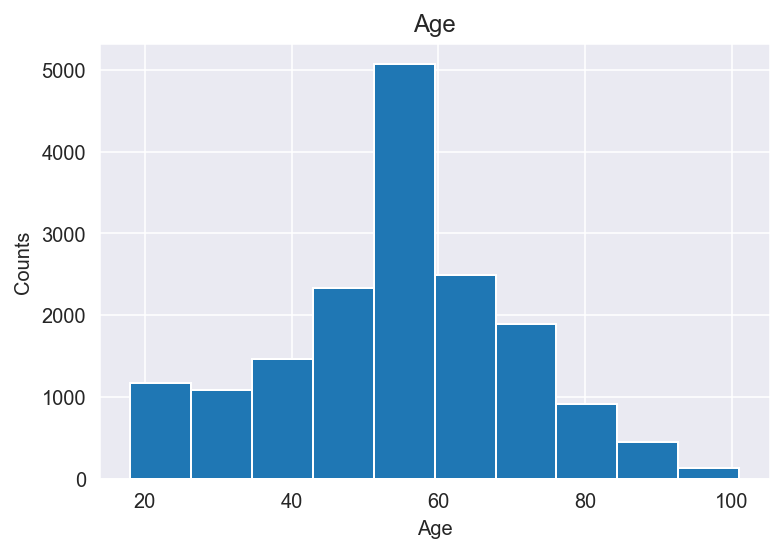

In [1343]:
plt.hist(profile['age'])
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Counts');

In [1344]:
profile.head()

,gender,age,user_id,became_member_on,income
0,other,54.393524,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568
1,F,55.000000,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000
2,other,54.393524,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65404.991568
3,F,75.000000,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000
4,other,54.393524,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65404.991568


### transcript

In [1345]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [1346]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [1347]:
#rename person to user_id
transcript=transcript.rename(columns={"person": "user_id"})

In [1348]:
# # one hot encode 'event'
event_list=['offer received', 'offer viewed', 'transaction', 'offer completed']
transcript=pd.concat([transcript,pd.get_dummies(transcript['event'])],axis=1).drop(['event'],axis=1)

In [1349]:
transcript=transcript.rename(columns={'offer received': 'offer_received',
                                      'offer viewed':'offer_viewed',
                                     'offer completed':'offer_completed'})

In [1350]:
transcript.head()

,user_id,value,time,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [1351]:
#extract the value from 'value' and creat dataframe for offer and transaction
transcript_offer=transcript.copy()
transcript_tran=transcript.copy()


transcript_offer['offer_id']=transcript_offer['value'].apply(lambda x: list(x.values())[0] if 
                                                             (list(x.keys())[0] == 'offer id' or list(x.keys())[0] == 'offer_id') else np.nan)
transcript_tran['amount']=transcript_tran['value'].apply(lambda x: list(x.values())[0] if list(x.keys())[0] == 'amount' else np.nan)

In [1352]:
#drop the orginal cloumns
transcript_offer=transcript_offer.drop(['value','transaction'],axis=1).dropna(axis=0)
transcript_tran=transcript_tran.drop(['value','offer_completed','offer_received','offer_viewed','transaction'],axis=1).dropna(axis=0)

In [1353]:
transcript_tran.head()

,user_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [1354]:
#groupby user_id and offer_id, and sum offer_completed offer_received offer_viewed
#this dataframe represents the status of offers for every users 
transcript_offer=transcript_offer.groupby(['user_id','offer_id']).sum().reset_index().drop(['time'],axis=1)
transcript_offer

,user_id,offer_id,offer_completed,offer_received,offer_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1
...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1


## Combine dataframe to master dataframe df_offer, df_tran

In [1355]:
transcript_offer.head(1)

,user_id,offer_id,offer_completed,offer_received,offer_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0


In [1356]:
profile.head(1)

,gender,age,user_id,became_member_on,income
0,other,54.393524,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65404.991568


In [1357]:
portfolio.head(1)

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1


In [1358]:
df_offer=pd.merge(pd.merge(transcript_offer,profile, on='user_id',how='left'),portfolio,on='offer_id',how='left')

In [1359]:
df_tran=pd.merge(transcript_tran,profile, on='user_id',how='left')

In [1360]:
df_tran.head()

,user_id,time,amount,gender,age,became_member_on,income
0,02c083884c7d45b39cc68e1314fec56c,0,0.83,F,20.0,2016-07-11,30000.0
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,M,42.0,2016-01-17,96000.0
2,54890f68699049c2a04d415abc25e717,0,13.23,M,36.0,2017-12-28,56000.0
3,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,F,55.0,2017-10-16,94000.0
4,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,F,39.0,2017-12-17,67000.0


In [1361]:
df_offer.head()

,user_id,offer_id,offer_completed,offer_received,offer_viewed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,M,33.0,2017-04-21,72000.0,2,10,7,discount,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,M,33.0,2017-04-21,72000.0,0,0,4,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,M,33.0,2017-04-21,72000.0,0,0,3,informational,0,1,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,M,33.0,2017-04-21,72000.0,5,5,5,bogo,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,M,33.0,2017-04-21,72000.0,2,10,10,discount,1,1,1,1


## EDA

### Q1: Are there any relationship between transaction amount and customer's profile?

In [1362]:
#calculate the total amount of transcation and add offer details
df_amount=pd.merge(pd.merge(df_tran.groupby('user_id')['amount'].sum(),profile, on='user_id',how='left'),
                   df_offer.groupby('user_id')['offer_completed','offer_received','offer_viewed'].sum(),on='user_id',how='left')

<ipython-input-1362-4d6ea6fa729f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_offer.groupby('user_id')['offer_completed','offer_received','offer_viewed'].sum(),on='user_id',how='left')


In [1363]:
df_amount.head()

,user_id,amount,gender,age,became_member_on,income,offer_completed,offer_received,offer_viewed
0,0009655768c64bdeb2e877511632db8f,127.60,M,33.000000,2017-04-21,72000.000000,3.0,5.0,4.0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,other,54.393524,2018-04-25,65404.991568,0.0,2.0,2.0
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,O,40.000000,2018-01-09,57000.000000,3.0,5.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,196.86,F,59.000000,2016-03-04,90000.000000,3.0,5.0,3.0
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,F,24.000000,2016-11-11,60000.000000,3.0,4.0,4.0


In [1364]:
df_amount.groupby('gender').mean()

,amount,age,income,offer_completed,offer_received,offer_viewed
gender,,,,,,
F,144.117304,57.472218,71132.154180,2.584238,4.485891,3.396226
M,101.855438,52.018927,61001.928873,1.985291,4.493972,3.332891
O,129.198725,54.294118,62916.666667,2.455882,4.318627,3.632353
other,19.419736,54.393524,65404.991568,0.544365,4.496882,3.601439


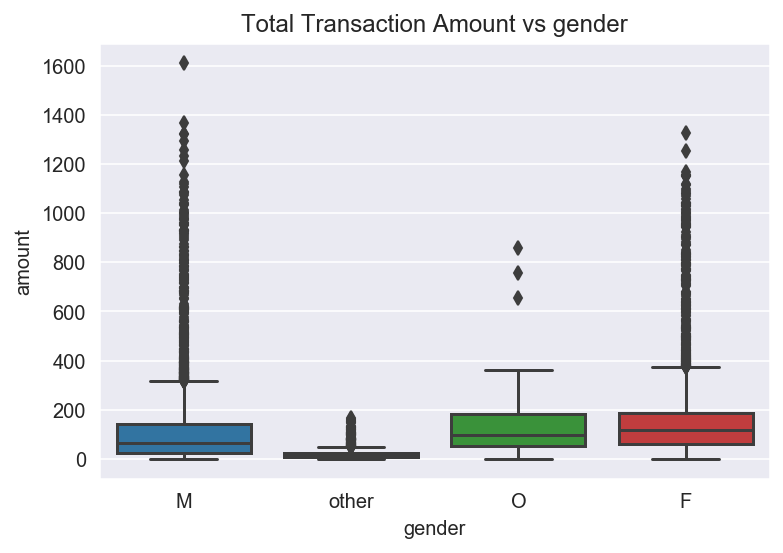

In [1365]:
sb.boxplot(x="gender", y="amount",
                 data=df_amount)
plt.title('Total Transaction Amount vs gender');

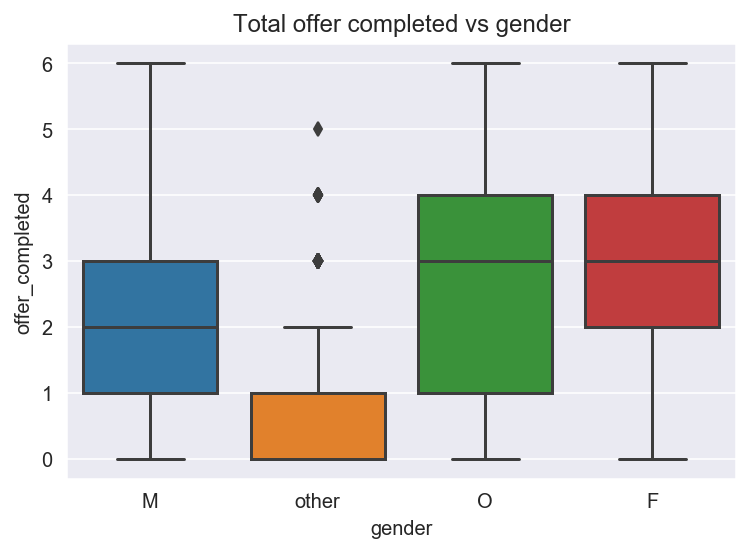

In [1366]:
sb.boxplot(x="gender", y="offer_completed",
                 data=df_amount)
plt.title('Total offer completed vs gender');

> female customer spends more than male and other, the group of people have no gender/age/income information (other) spend a lot less than other customer   
female complete more offers than male
the group of people have no gender/age/income information (other) do not tend to complete offer

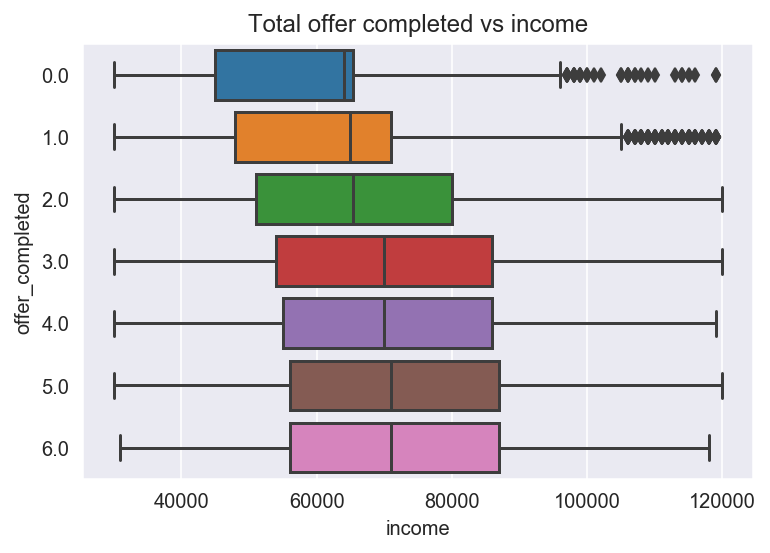

In [1367]:
sb.boxplot(x="income", y="offer_completed" ,orient = 'h' , data=df_amount)
plt.title('Total offer completed vs income');

### Q2: What are the offer received,viewed and compeleted rate?

In [1368]:
#calculate the total offers for 'offer_completed','offer_received','offer_viewed'
df_offer_detail=df_offer.groupby('offer_id')['offer_completed','offer_received','offer_viewed'].sum().reset_index()

<ipython-input-1368-38d02888c166>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_offer_detail=df_offer.groupby('offer_id')['offer_completed','offer_received','offer_viewed'].sum().reset_index()


In [1369]:
#calculate view, complete rate
df_offer_detail['viewed_rate']=df_offer_detail['offer_viewed']/df_offer_detail['offer_received']

In [1370]:
df_offer_detail['completed_rate_received']=df_offer_detail['offer_completed']/df_offer_detail['offer_received']

In [1371]:
df_offer_detail['completed_rate_viewed']=df_offer_detail['offer_completed']/df_offer_detail['offer_viewed']

In [1372]:
df_offer_detail=pd.merge(df_offer_detail,portfolio,on='offer_id')

In [1373]:
df_offer_detail

,offer_id,offer_completed,offer_received,offer_viewed,viewed_rate,completed_rate_received,completed_rate_viewed,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3420.0,7668.0,2663.0,0.347287,0.446009,1.284266,5,20,10,discount,1,1,0,0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5156.0,7646.0,7337.0,0.959587,0.674340,0.702740,3,7,7,discount,1,1,1,1
2,2906b810c7d4411798c6938adc9daaa5,4017.0,7632.0,4118.0,0.539570,0.526336,0.975474,2,10,7,discount,1,1,1,0
3,3f207df678b143eea3cee63160fa8bed,0.0,7617.0,4144.0,0.544046,0.000000,0.000000,0,0,4,informational,1,1,1,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,3331.0,7593.0,7298.0,0.961148,0.438694,0.456426,10,10,5,bogo,1,1,1,1
5,5a8bc65990b245e5a138643cd4eb9837,0.0,7618.0,6687.0,0.877789,0.000000,0.000000,0,0,3,informational,0,1,1,1
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,4354.0,7677.0,4171.0,0.543311,0.567149,1.043874,5,5,7,bogo,1,1,1,0
7,ae264e3637204a6fb9bb56bc8210ddfd,3688.0,7658.0,6716.0,0.876991,0.481588,0.549136,10,10,7,bogo,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,4296.0,7571.0,7264.0,0.959451,0.567428,0.591410,5,5,5,bogo,1,1,1,1
9,fafdcd668e3743c1bb461111dcafc2a4,5317.0,7597.0,7327.0,0.964460,0.699882,0.725672,2,10,10,discount,1,1,1,1


> note that some of the offers have higher offer_completed than offer_viewed, which means some customers still complete the offer even they do know the offer. The company should not need to issue the offer to them, they will spend anyway. This may be considered as a loss and can be improved.

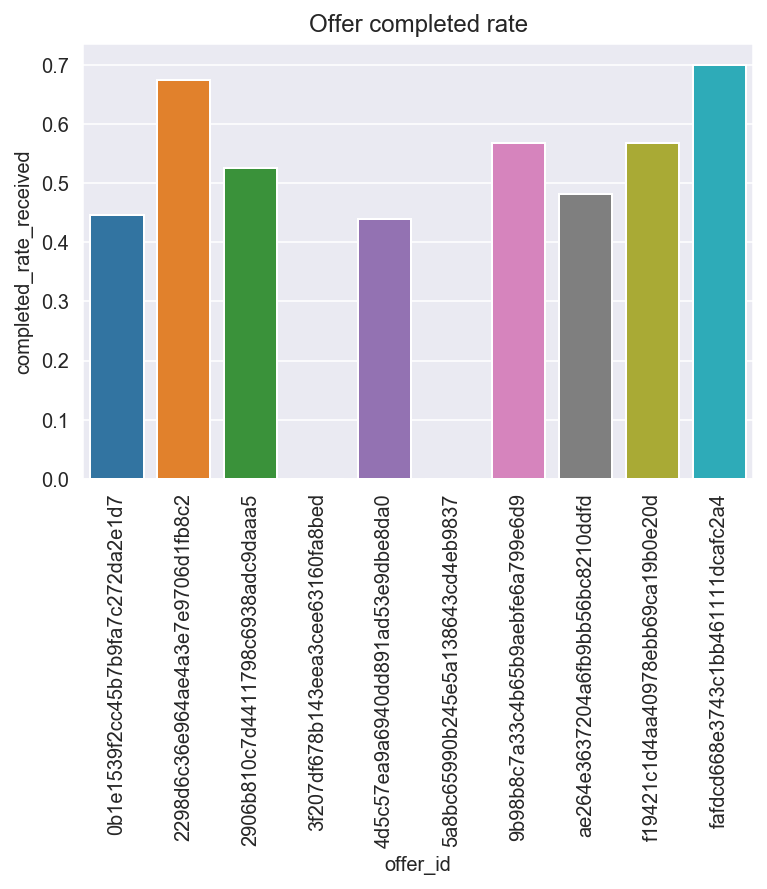

In [1374]:
sb.barplot(x="offer_id", y="completed_rate_received" , data=df_offer_detail)
plt.xticks(rotation=90)
plt.title('Offer completed rate');

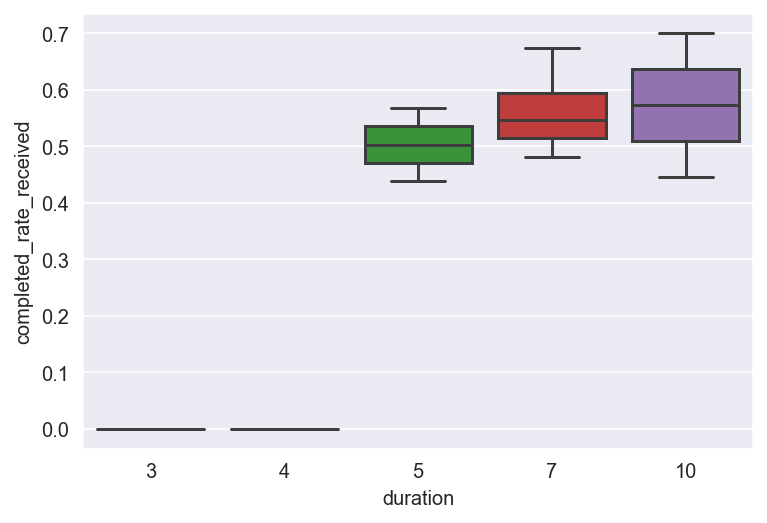

In [1375]:
sb.boxplot(x="duration", y="completed_rate_received" , data=df_offer_detail);

> with longer duration, the offer completed rate seem to be higher

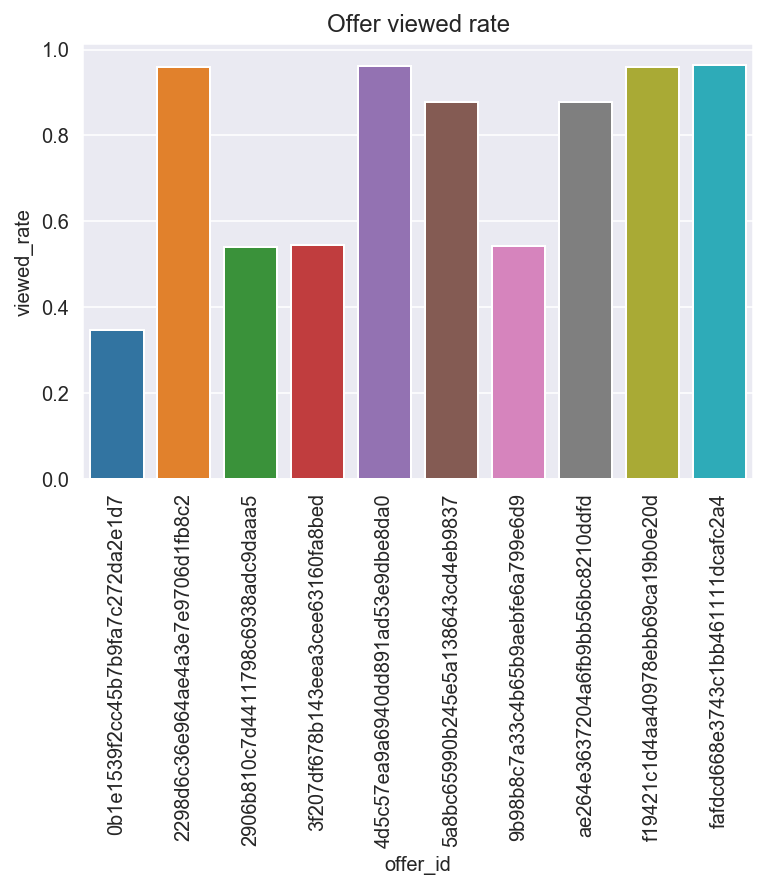

In [1376]:
sb.barplot(x="offer_id", y="viewed_rate" , data=df_offer_detail)
plt.xticks(rotation=90)
plt.title('Offer viewed rate');

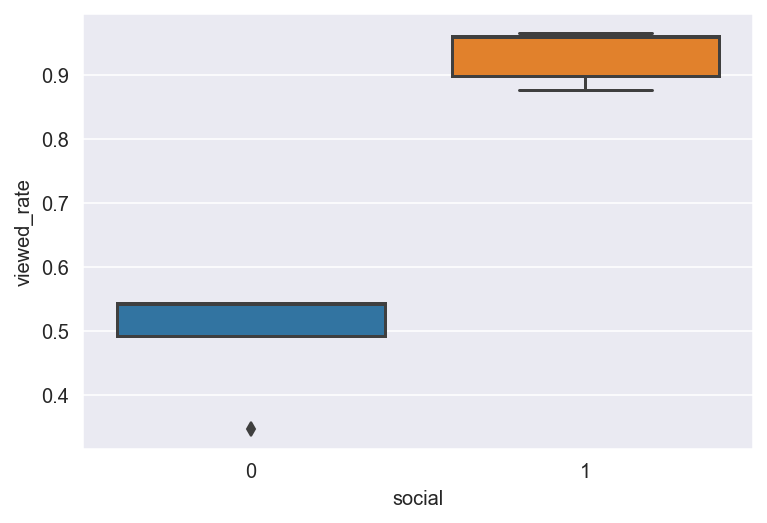

In [1377]:
sb.boxplot(x="social", y="viewed_rate" , data=df_offer_detail);

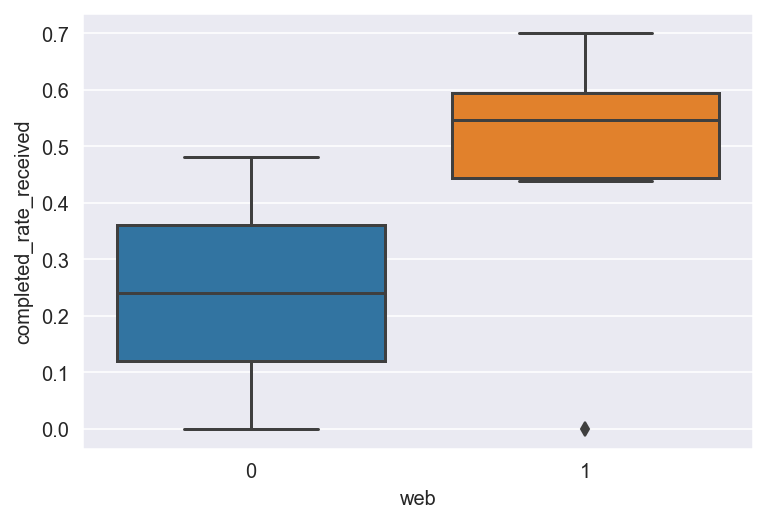

In [1378]:
sb.boxplot(x="web", y="completed_rate_received" , data=df_offer_detail);

> when the channels includes social media, the offer viewed rate are signigicantly higher (0.5 to 0.9)

## Machine Learning model

Predict who will view or compelte the offer

### View offer?

In [1285]:
df_offer.head()

,user_id,offer_id,offer_completed,offer_received,offer_viewed,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,M,33.0,2017-04-21,72000.0,2,10,7,discount,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,M,33.0,2017-04-21,72000.0,0,0,4,informational,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,M,33.0,2017-04-21,72000.0,0,0,3,informational,0,1,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,M,33.0,2017-04-21,72000.0,5,5,5,bogo,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,M,33.0,2017-04-21,72000.0,2,10,10,discount,1,1,1,1


In [1286]:
#convert datetime object to three columns
df_offer['became_member_on_y']=df_offer['became_member_on'].apply(lambda x: x.year)
df_offer['became_member_on_m']=df_offer['became_member_on'].apply(lambda x: x.month)
df_offer['became_member_on_d']=df_offer['became_member_on'].apply(lambda x: x.day)

In [1287]:
df_offer=df_offer.drop(['became_member_on'],axis=1)

In [1288]:
#one hot encode 'offer_type','gender','offer_id'

df_offer=pd.concat([df_offer,pd.get_dummies(df_offer['offer_type'],prefix='offer')],axis=1).drop(['offer_type'],axis=1)

In [1289]:
df_offer=pd.concat([df_offer,pd.get_dummies(df_offer['gender'],prefix='gender')],axis=1).drop(['gender'],axis=1)

In [1290]:
df_offer=pd.concat([df_offer,pd.get_dummies(df_offer['offer_id'],prefix='offer_id')],axis=1).drop(['offer_id'],axis=1)

In [1291]:
df_offer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    63288 non-null  object 
 1   offer_completed                            63288 non-null  uint8  
 2   offer_received                             63288 non-null  uint8  
 3   offer_viewed                               63288 non-null  uint8  
 4   age                                        63288 non-null  float64
 5   income                                     63288 non-null  float64
 6   reward                                     63288 non-null  int64  
 7   difficulty                                 63288 non-null  int64  
 8   duration                                   63288 non-null  int64  
 9   web                                        63288 non-null  int64  
 10  email                 

In [1292]:
df_offer.columns

Index(['user_id', 'offer_completed', 'offer_received', 'offer_viewed', 'age',
       'income', 'reward', 'difficulty', 'duration', 'web', 'email', 'mobile',
       'social', 'became_member_on_y', 'became_member_on_m',
       'became_member_on_d', 'offer_bogo', 'offer_discount',
       'offer_informational', 'gender_F', 'gender_M', 'gender_O',
       'gender_other', 'offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_3f207df678b143eea3cee63160fa8bed',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_f19421c1d4aa40978ebb69ca19b0e20d',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4'],
      dtype='object')

In [1293]:
from sklearn.model_selection import train_test_split

In [1294]:
#select features for training
X=df_offer.drop(['user_id','offer_completed', 'offer_received', 'offer_viewed'],axis=1)
# if offer_view >1 --> change to 1
y = (df_offer['offer_viewed']>0).astype(int)

In [1295]:
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1296]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [1297]:
#build random forest classifer
rf_view = RandomForestClassifier(n_estimators=200,max_depth=25, random_state=42,class_weight='balanced')

In [1298]:
rf_view.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, n_estimators=200,
                       random_state=42)

In [1299]:
y_pred_view=rf_view.predict(X_test)

In [1300]:
print("Test Accuracy (view): {0:.5f}".format(accuracy_score(y_test, y_pred_view)))

Test Accuracy (view): 0.81013


''

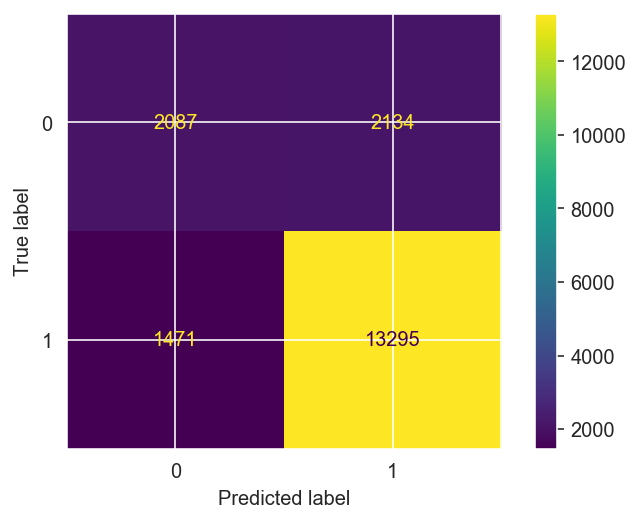

In [1301]:
from sklearn.metrics import plot_confusion_matrix
cm=confusion_matrix(y_test, y_pred_view)
plot_confusion_matrix(rf_view, X_test, y_test)
;

> Random forest model is able to predict wether customer views the offer with 81% accuracy

In [1302]:
# check feature importance
feature_imp_view = pd.Series(rf_view.feature_importances_,index=X_train.columns).sort_values(ascending=False).reset_index()
feature_imp_view=feature_imp_view.rename(columns={'index':'feature',0:'importance'})

''

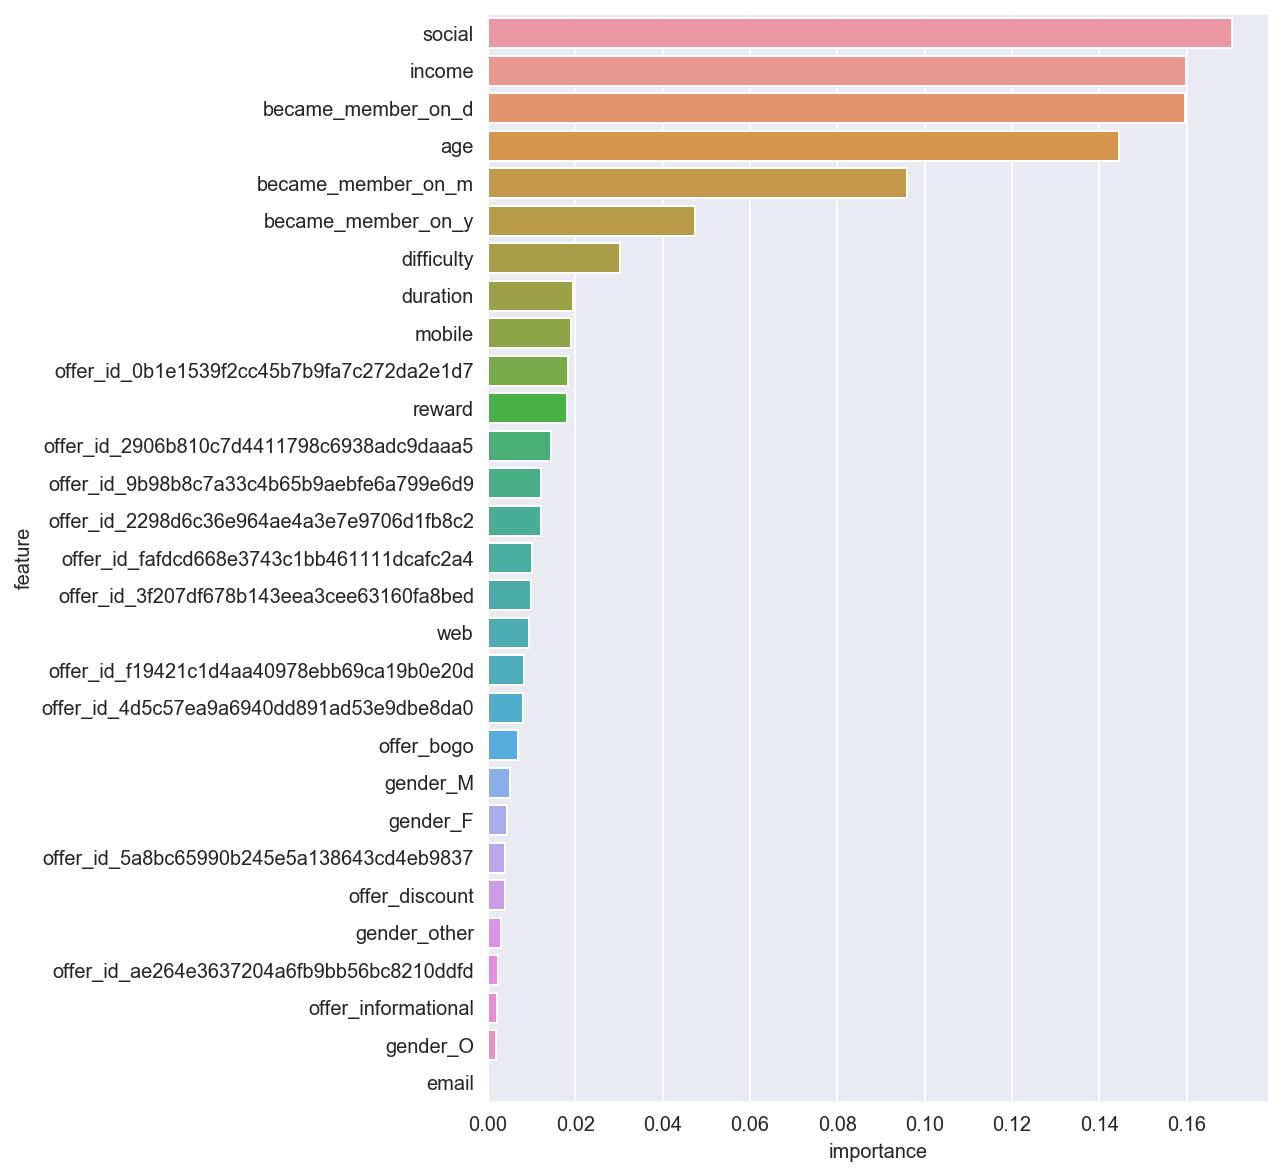

In [1303]:
plt.figure(figsize=(7,10))
sb.barplot(y='feature',x='importance',data=feature_imp_view)
;

> The most important feature for viewing the offer is wether the offer is from social media channels  
Income, when to become member and age are also important

### offer completed?

In [1304]:
X_c=df_offer.drop(['user_id','offer_completed', 'offer_received', 'offer_viewed'],axis=1)
y_c = (df_offer['offer_completed']>0).astype(int)

In [1305]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.3, random_state=42)

In [1313]:
rf_c = RandomForestClassifier(n_estimators=200,max_depth=15, random_state=42)
rf_c.fit(X_train,y_train)
y_pred_c=rf_c.predict(X_test)
print("Test Accuracy (completed): {0:.5f}".format(accuracy_score(y_test, y_pred_c)))

Test Accuracy (completed): 0.78838


''

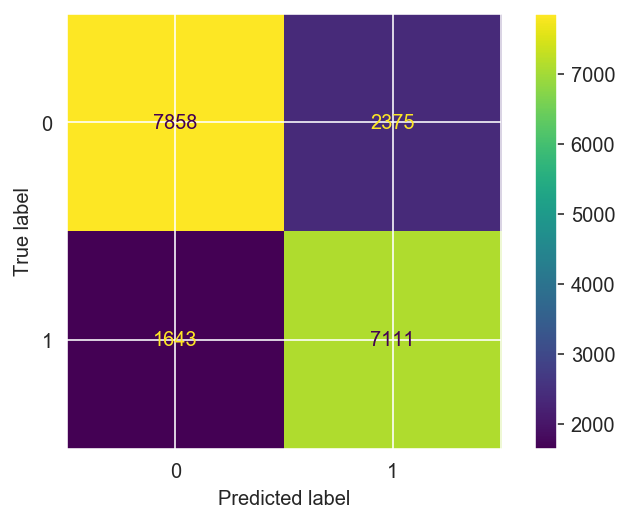

In [1307]:
cm=confusion_matrix(y_test, y_pred_view)
plot_confusion_matrix(rf_c, X_test, y_test)
;

> Random forest model is able to predict wether customer completes the offer with 78.8% accuracy

In [1308]:
feature_imp_c = pd.Series(rf_c.feature_importances_,index=X_train.columns).sort_values(ascending=False).reset_index()
feature_imp_c=feature_imp_c.rename(columns={'index':'feature',0:'importance'})

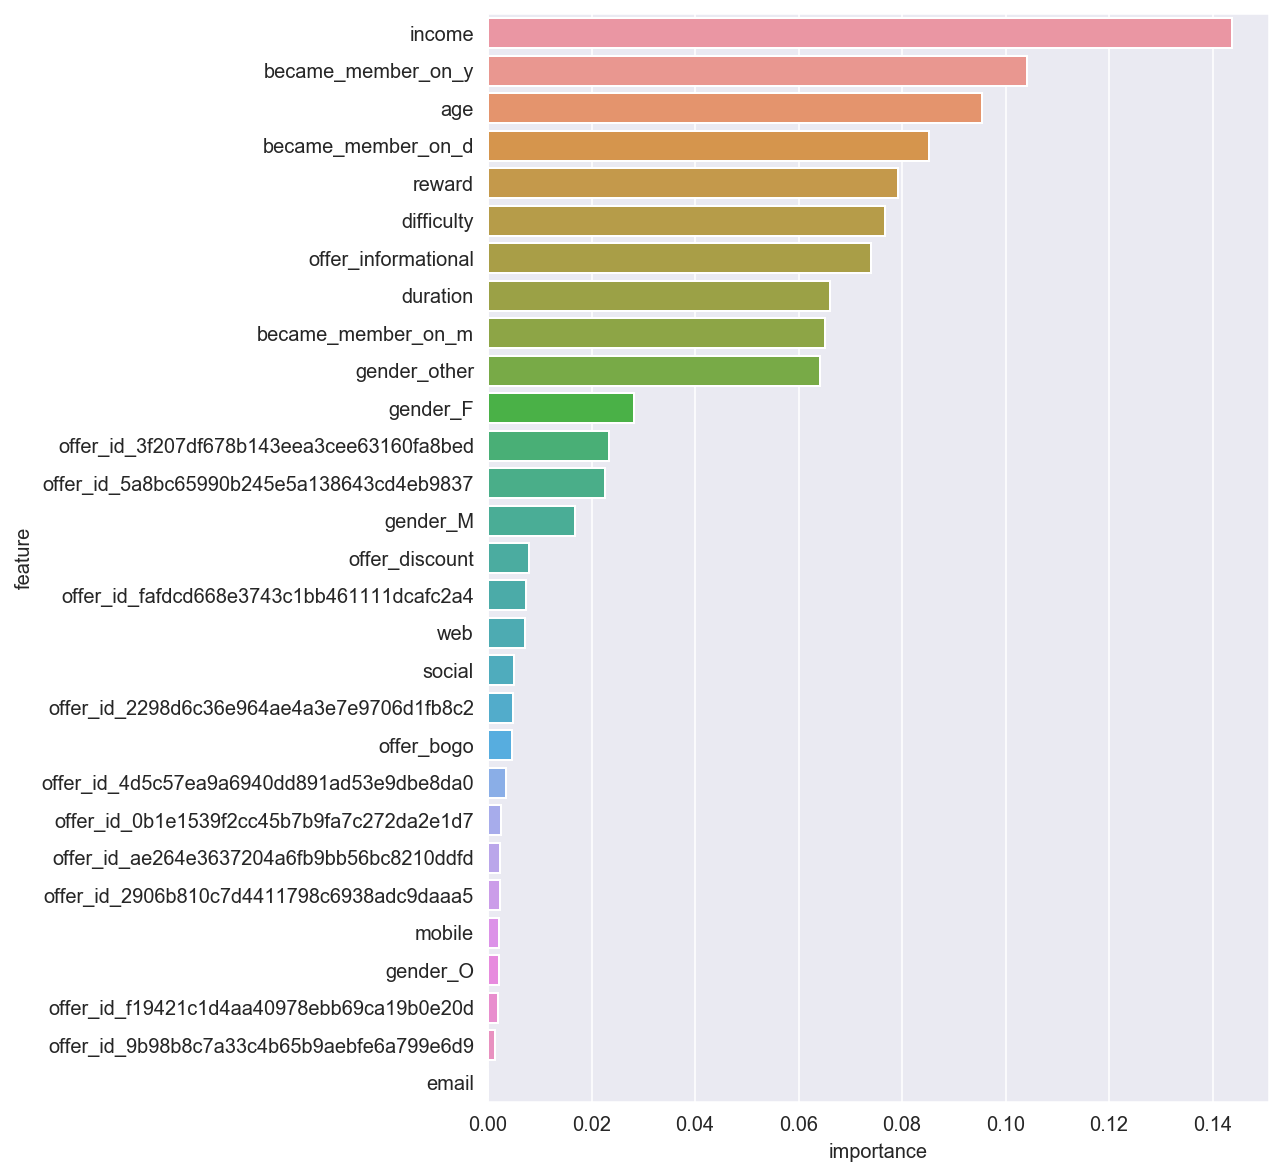

In [1309]:
plt.figure(figsize=(7,10))
sb.barplot(y='feature',x='importance',data=feature_imp_c);

> The most important feature for completing the offer is income of the customer  
the age and when to become member, reward, difficilty and duratio of the offer also impact the offer completion

## Conclusion

Some conclusions can be made based on the data analysis and models:
1. Female customers spend more than male and other
2. Female customers complete more offers than male
3. There are a group of people do not provide gender/age/income information   
    3.1 This gropu of people spend a lot less than other customer   
    3.2 They do not tend to complete offer
4. When the channels include social media, the offer viewed rate are signigicantly higher (0.5 to 0.9)
5. With longer offer duration, the offer completed rate seem to be higher
6. Random forest model is able to predict wether customer views the offer with 81% accuracy
    6.1 The most important feature for viewing the offer is wether the offer is from social media channels  
    6.2 Income, when to become member and age are also important
7. Random forest model is able to predict wether customer completes the offer with 78.8% accuracy
    7.1 The most important feature for completing the offer is wether the income of the customer  
    7.2 The age and when to become member, reward, difficilty and duratio of the offer also impact the offer completion

### Improvements

There are still rooms for improvement, for example, grid serach for better model parameters, try differernt model like SVM for XGBoost. It is also possible to dig deeper in feature engineering, for example, the feature 'time' was not used in this model, it might be useful.  
One potential cost saving opportunity for Starbucks is that some costumers completed the offers even they did not view the offer. This means this group of customer will consume anyway wether there are offers or not. Therefore it might be interesting to build a model to identify these customers can do not issue offer for them.